In [2]:
from glob import glob
import os

import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
from matplotlib import cm
import geopandas as gpd
import rioxarray as rxr
import xarray as xr
from rasterio.plot import plotting_extent
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
from shapely.geometry import box

from osgeo import gdal

# optional - turn off warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
os.chdir('/users/marianne/documents/pe_snow_fires/')
files = os.listdir('pedata')
f = os.path.join(os.getcwd(),'pedata',files[1])

<AxesSubplot:>

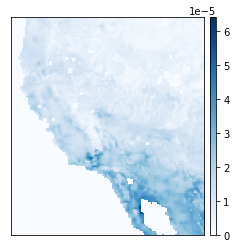

In [4]:
fig,ax=plt.subplots()
pe = rxr.open_rasterio(f,decode_times=False)
ep.plot_bands(pe,ax=ax,cmap='Blues',vmin=0, vmax=np.nanmax(pe.data))


In [5]:
sn_trans = sn.to_crs(pe.rio.crs)
sn_geom = sn.to_crs(pe.rio.crs)

from rasterio.plot import plotting_extent
#  Create a box representing the spatial extent of your data
crop_bound_box = [box(*sn.total_bounds)]
# Clip the data by  chaining together rio.clip with rio.open_rasterio
# from_disk=True allows you to only open the data that you wish to work with
pe_clip = pe.rio.clip(crop_bound_box, crs=sn.crs,
                                    # Include all pixels even partial pixels
                                    all_touched=True,
                                    from_disk=True).squeeze()


pe_ext = plotting_extent(pe_clip,
                            pe_clip.rio.transform())


NameError: name 'sn' is not defined

NameError: name 'pe_clip' is not defined

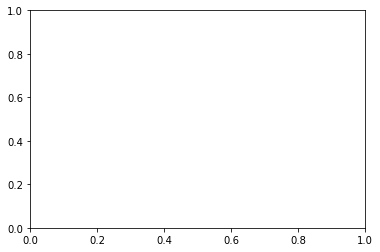

In [5]:
import matplotlib
cols = cm.get_cmap('BrBG', 256)
newcolors = cols(np.linspace(0, 1.5, 256))
white = np.array([1,1,1,0])
newcolors[:1, :] = white
newcmp = matplotlib.colors.ListedColormap(newcolors)

fig,ax=plt.subplots()
# Plotting Bounds Clip
maxval=np.nanmax(pe_clip.values)
pe_clip = pe.rio.clip(sn_geom.geometry,
                    all_touched=True,
                    from_disk=True)
ep.plot_bands(pe_clip,
            ax=ax,
            extent=pe_ext,
            cbar=True, 
            cmap = newcmp,
            title = '2016-09-09',
            vmin=2e-5, vmax=maxval)

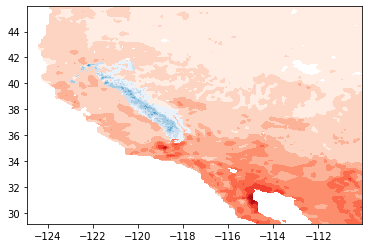

In [5]:
import h5py
from shapely.geometry import Point
os.chdir('/users/marianne/documents/data/reanalysis/')
dailyswe = np.load('daily_swe_avg.npy', allow_pickle=True)
maxday = np.load('max_day.npy', allow_pickle=True)
maxswe = np.load('max_swe.npy', allow_pickle=True)

os.chdir('/users/marianne/documents/data/reanalysis/h5/')
for yr in range(1985 , 1986):
    hf = h5py.File('SN_SWE_WY'+ str(yr) + '.h5', 'r')
    swe = hf.get('SWE')
    day = maxday[yr-1985]
    swe_tmp = swe[day,:,:].astype('float')
    swe_tmp[swe_tmp<0]=np.nan

os.chdir('/users/marianne/documents/pe_snow_fires/')
files = os.listdir('pedata')
f = os.path.join(os.getcwd(),'pedata',files[1])
pe = rxr.open_rasterio(f,decode_times=False)


lon = [i[0] for i in hf.get('lon').value]
lat = [i for i in hf.get('lat').value[0]]
geometry = [Point(xy) for xy in zip(lon,lat)]

x_, y_ = np.meshgrid(lat, lon)
z_grid = np.array(swe_tmp)# .reshape(len(lat),len(lon))

x,y = np.meshgrid(pe['x'],pe['y'])
z = pe.values[0,:,:]
z[z<0]=np.nan
fig,ax=plt.subplots()
ax.contourf(x,y,z,cmap='Reds')
ax.contourf(y_,x_,z_grid,cmap='Blues')
plt.show()


In [62]:
import re

os.chdir('/users/marianne/documents/pe_snow_fires/')
yr=str(1979)
mo = "09"
d = '20'
files = os.listdir('pedata')
result = [f for f in files if re.search(r''+mo+d, f)] 

print(result)
#f = os.path.join(os.getcwd(),'pedata',files[1])
#pe = rxr.open_rasterio(f,decode_times=False)


['NCALDAS_NOAH0125_D.A19790920.002.nc4.SUB.tif', 'NCALDAS_NOAH0125_D.A19800920.002.nc4.SUB.tif', 'NCALDAS_NOAH0125_D.A19810920.002.nc4.SUB.tif', 'NCALDAS_NOAH0125_D.A19820920.002.nc4.SUB.tif', 'NCALDAS_NOAH0125_D.A19830920.002.nc4.SUB.tif', 'NCALDAS_NOAH0125_D.A19840920.002.nc4.SUB.tif', 'NCALDAS_NOAH0125_D.A19850920.002.nc4.SUB.tif', 'NCALDAS_NOAH0125_D.A19860920.002.nc4.SUB.tif', 'NCALDAS_NOAH0125_D.A19870920.002.nc4.SUB.tif', 'NCALDAS_NOAH0125_D.A19880920.002.nc4.SUB.tif', 'NCALDAS_NOAH0125_D.A19890920.002.nc4.SUB.tif', 'NCALDAS_NOAH0125_D.A19900920.002.nc4.SUB.tif', 'NCALDAS_NOAH0125_D.A19910920.002.nc4.SUB.tif', 'NCALDAS_NOAH0125_D.A19920920.002.nc4.SUB.tif', 'NCALDAS_NOAH0125_D.A19930920.002.nc4.SUB.tif', 'NCALDAS_NOAH0125_D.A19940920.002.nc4.SUB.tif', 'NCALDAS_NOAH0125_D.A19950920.002.nc4.SUB.tif', 'NCALDAS_NOAH0125_D.A19960920.002.nc4.SUB.tif', 'NCALDAS_NOAH0125_D.A19970920.002.nc4.SUB.tif', 'NCALDAS_NOAH0125_D.A19980920.002.nc4.SUB.tif', 'NCALDAS_NOAH0125_D.A19990920.002.nc4.S

In [54]:
from osgeo import gdal, osr, ogr
import numpy as np
#create a grid
lats = lat
lons = lon
mag_grid = swe_tmp.transpose()

xres = lons[1] - lons[0]
yres = lats[1] - lats[0]
ysize = len(lats)
xsize = len(lons)
ulx = lons[0] - (xres / 2.)
uly = lats[-1] - (yres / 2.)


driver = gdal.GetDriverByName('GTiff')
ds = driver.Create('swe_test.tif',
               xsize, ysize, 1, gdal.GDT_Float32, )
##################################
#pixel type of gdal.GDT_Float32 results in transparent image
##################################

# this assumes the projection is Geographic lat/lon WGS 84
srs = osr.SpatialReference()
srs.ImportFromEPSG(4326)
ds.SetProjection(srs.ExportToWkt())
gt = [ulx, xres, 0, uly, 0, yres ]
ds.SetGeoTransform(gt)
outband=ds.GetRasterBand(1)
outband.SetStatistics(np.min(mag_grid), np.max(mag_grid), np.average(mag_grid), np.std(mag_grid))
outband.WriteArray(mag_grid)
ds = None

In [32]:
print(outband.XSize)
print(outband.YSize)
print(mag_grid.shape)

5701
6601
(5701, 6601)


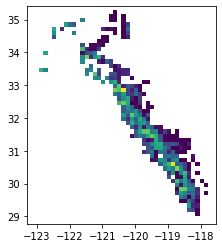

In [56]:
import rasterio
from rasterio.plot import show
fp = r'output_test.tif'
img = rasterio.open(fp)
show(img)
img.close()

In [39]:
!gdalinfo 'c:/users/marianne/documents/pe_snow_fires/pedata/NCALDAS_NOAH0125_D.A19790103.002.nc4.SUB.tif'


ERROR 4: `'c:/users/marianne/documents/pe_snow_fires/pedata/NCALDAS_NOAH0125_D.A19790103.002.nc4.SUB.tif'' does not exist in the file system, and is not recognized as a supported dataset name.
gdalinfo failed - unable to open ''c:/users/marianne/documents/pe_snow_fires/pedata/NCALDAS_NOAH0125_D.A19790103.002.nc4.SUB.tif''.


In [41]:
# gdal.Warp('outputRaster.tif', 'inputRaster.tif', xRes=5, yRes=5)
# gdal.Warp('outputRaster.tif', 'inputRaster.tif', xRes=5, yRes=5)
print(f)
os.getcwd()

c:\users\marianne\documents\pe_snow_fires\pedata\NCALDAS_NOAH0125_D.A19790103.002.nc4.SUB.tif


'c:\\users\\marianne\\documents\\pe_snow_fires'

In [43]:
!gdalwarp -t_srs <(!gdalsrsinfo -o wkt 'c:/users/marianne/documents/pe_snow_fires/pedata/NCALDAS_NOAH0125_D.A19790103.002.nc4.SUB.tif') 'swe_test.tif' 'output.tif'

The system cannot find the file specified.


ERROR 1: ERROR - failed to load SRS definition from 'c:/users/marianne/documents/pe_snow_fires/pedata/NCALDAS_NOAH0125_D.A19790103.002.nc4.SUB.tif'
